In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import random

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph, errorDist
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph, groupWithFrequency,\
                train_3d_graph_origin

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}
sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addWt = ADD_data_loader(wt_fileList)
print("winter data:",addWt.shape)
print("")
addSp = ADD_data_loader(sp_fileList)
print("spring data:",addSp.shape)
print("")
addSm = ADD_data_loader(sm_fileList)
print("summer data:",addSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addWt, addSp, addSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(22532, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(22505, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(22518, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 1719    m      1.00    100.29      0.02       0        400       100        7        2
     1720    m      1.00    124.49      0.04       0        400       100        7        2
     1721    m      1.00     92.21      0.03       0        400       100        7        2
     1722    m      1.00     93.33      0.01       0        400       100        7        2
     1723    m      1.00    100.66      0.02       0        400       100        7        2
C

data distribution(before)
       logDistance  logFrequency  pathloss
count    123134.00     123134.00 123134.00
mean          0.39          3.04    127.74
std           0.16          0.31     14.12
min           0.00          2.60     85.47
25%           0.28          2.60    117.05
50%           0.41          3.15    128.39
75%           0.52          3.35    138.74
max           0.60          3.35    171.41
sampling shape(before):(123134, 3)
sampling shape(after):(6157, 3)
data distribution(after)
       logDistance  logFrequency  pathloss
count      6157.00       6157.00   6157.00
mean          0.39          3.04    127.88
std           0.15          0.31     13.66
min           0.00          2.60     85.67
25%           0.29          2.60    117.68
50%           0.41          3.15    128.51
75%           0.52          3.35    138.49
max           0.60          3.35    165.48
normalization distribution(before):
       logDistance  logFrequency  pathloss
count      6157.00       6157

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


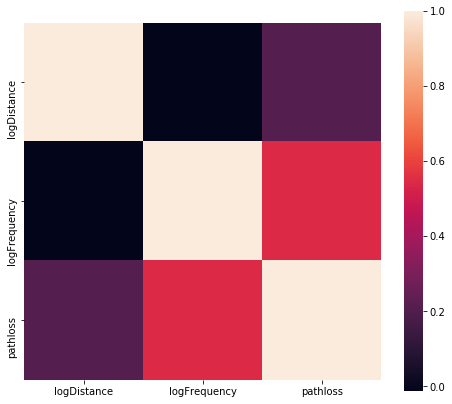

In [3]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'pathloss']
xCols = ['logDistance', 'logFrequency']
yCols = 'pathloss'

samplingRatio = 0.05
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

bestANNModel = None
bestANNIdx = 0
modelList = []
dataSet = []
i = 1
prevTestError = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = 'model/ann_'+sc+'-'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestANNIdx = i
        
    if prevTestError > testError:
        bestANNModel = model
        bestANNIdx = i
        prevTestError = testError
    
    i+=1
print("bestIdx:",bestANNIdx)
print("best model:",bestANNModel)

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:10.418526262324695 / test:10.860081540631555
#2 Error(RMSE)-train:10.482192725339285 / test:10.576153672006695
#3 Error(RMSE)-train:10.455518810185957 / test:10.671200685082677
#4 Error(RMSE)-train:10.456818626936094 / test:10.5314352606026
#5 Error(RMSE)-train:10.56021434574457 / test:10.333457756299369
bestIdx: 5
best model: MLPRegressor(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-06, validation_fraction=0.1,
       verbose=False, warm_start=False)


3D graph for log distance and log frequency - trainset #6
logDistance      0.39
logFrequency     0.30
pathloss       127.88
dtype: float64
scatterX shape: (6157,)
scatterY shape: (6157,)
scatterZ shape: (6157, 1)
Index(['logDistance', 'logFrequency'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency
count     10000.00      10000.00
mean          0.30          0.30
std           0.18          0.02
min           0.00          0.26
25%           0.15          0.28
50%           0.30          0.30
75%           0.45          0.32
max           0.60          0.34


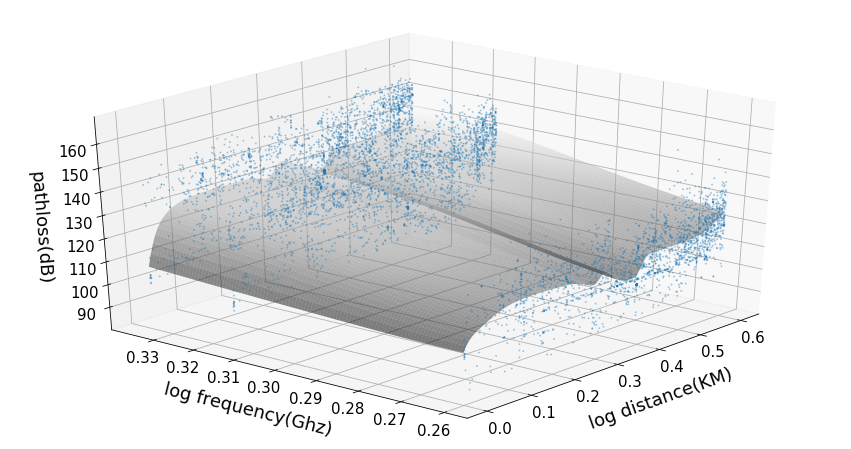

In [35]:
%autoreload
print("3D graph for log distance and log frequency - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
excludeCols = ['logDistance', 'logFrequency', 'pathloss']
varX = ['logDistance', 'logFrequency']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), excludeCols)

graphX = data[0]
graphY = data[1]
train_3d_graph_origin(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

data distribution(before)
       logDistance  logHeightTM  pathloss
count    123134.00    123134.00 123134.00
mean          0.39         1.35    127.74
std           0.16         0.19     14.12
min           0.00         1.00     85.47
25%           0.28         1.20    117.05
50%           0.41         1.33    128.39
75%           0.52         1.49    138.74
max           0.60         2.00    171.41
sampling shape(before):(123134, 3)
sampling shape(after):(6157, 3)
data distribution(after)
       logDistance  logHeightTM  pathloss
count      6157.00      6157.00   6157.00
mean          0.39         1.36    127.88
std           0.15         0.19     13.66
min           0.00         1.00     85.67
25%           0.29         1.20    117.68
50%           0.41         1.34    128.51
75%           0.52         1.49    138.49
max           0.60         1.98    165.48
normalization distribution(before):
       logDistance  logHeightTM  pathloss
count      6157.00      6157.00   6157.00
mean  

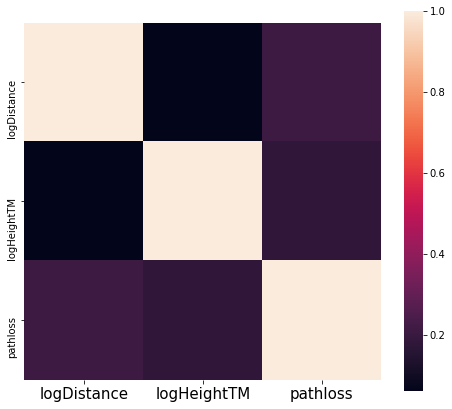

In [36]:
%autoreload

targetCols = ['logDistance', 'logHeightTM', 'pathloss']
xCols = ['logDistance', 'logHeightTM']
yCols = 'pathloss'

samplingRatio = 0.05
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

In [37]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

bestANNModel = None
bestANNIdx = 0
modelList = []
dataSet = []
i = 1
prevTestError = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = 'model/ann_'+sc+'-'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestANNIdx = i
        
    if prevTestError > testError:
        bestANNModel = model
        bestANNIdx = i
        prevTestError = testError
    
    i+=1
print("bestIdx:",bestANNIdx)
print("best model:",bestANNModel)

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:12.58329382211675 / test:12.688597898145476
#2 Error(RMSE)-train:12.560985280254501 / test:12.929039965608615
#3 Error(RMSE)-train:12.481359159433229 / test:12.785994459060937
#4 Error(RMSE)-train:12.682174895980115 / test:12.49248126128819
#5 Error(RMSE)-train:12.65508817475332 / test:12.548492126762579
bestIdx: 4
best model: MLPRegressor(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-06, validation_fraction=0.1,
       verbose=False, warm_start=False)


3D graph for log distance and log receiver antenna height - trainset #6
logDistance     0.39
logHeightTM     1.36
pathloss      127.88
dtype: float64
scatterX shape: (6157,)
scatterY shape: (6157,)
scatterZ shape: (6157, 1)
Index(['logDistance', 'logHeightTM'], dtype='object')
input data/feature distribution:
        logDistance  logHeightTM
count     10000.00     10000.00
mean          0.30         1.49
std           0.18         0.28
min           0.00         1.00
25%           0.15         1.24
50%           0.30         1.49
75%           0.45         1.73
max           0.60         1.98


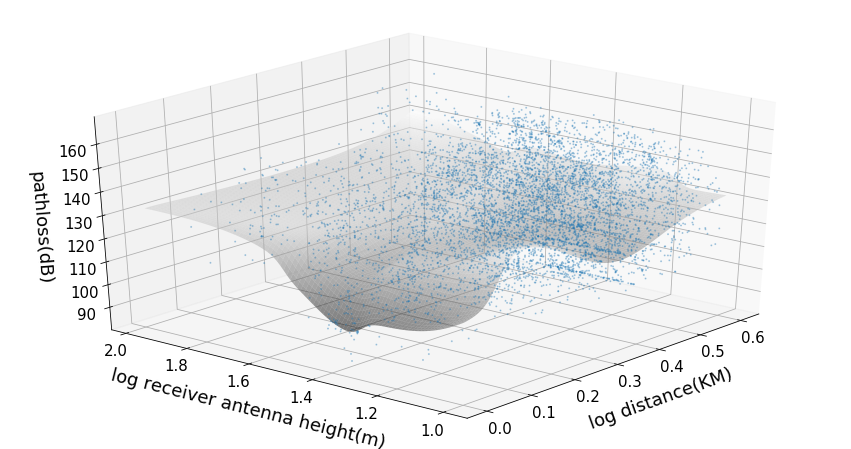

In [40]:
%autoreload
print("3D graph for log distance and log receiver antenna height - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","log receiver antenna height(m)","pathloss(dB)"
excludeCols = ['logDistance', 'logHeightTM', 'pathloss']
varX = ['logDistance', 'logHeightTM']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), excludeCols)

graphX = data[0]
graphY = data[1]
train_3d_graph_origin(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

data distribution(before)
       logDistance  logExtendedHeightTratio  pathloss
count    123134.00                123134.00 123134.00
mean          0.39                     0.64    127.74
std           0.16                     0.18     14.12
min           0.00                     0.02     85.47
25%           0.28                     0.51    117.05
50%           0.41                     0.66    128.39
75%           0.52                     0.78    138.74
max           0.60                     0.95    171.41
sampling shape(before):(123134, 3)
sampling shape(after):(12313, 3)
data distribution(after)
       logDistance  logExtendedHeightTratio  pathloss
count     12313.00                 12313.00  12313.00
mean          0.39                     0.64    127.79
std           0.15                     0.18     13.85
min           0.00                     0.04     85.51
25%           0.28                     0.51    117.55
50%           0.41                     0.66    128.31
75%           0.5

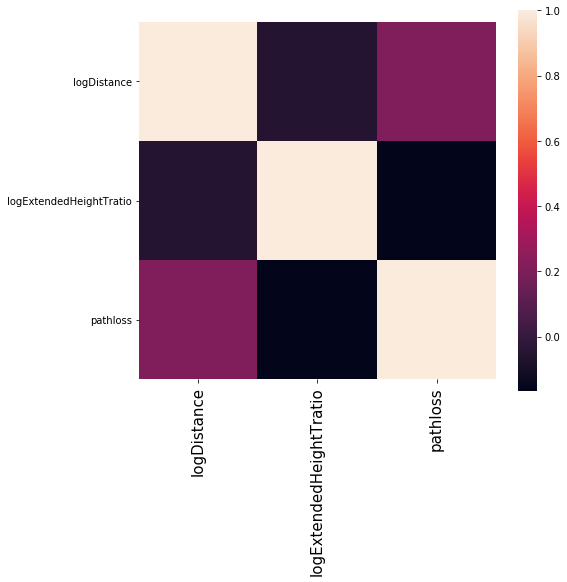

In [41]:
%autoreload

targetCols = ['logDistance', 'logExtendedHeightTratio', 'pathloss']
xCols = ['logDistance', 'logExtendedHeightTratio']
yCols = 'pathloss'

samplingRatio = 0.1
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

In [42]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

bestANNModel = None
bestANNIdx = 0
modelList = []
dataSet = []
i = 1
prevTestError = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = 'model/ann_'+sc+'-'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestANNIdx = i
        
    if prevTestError > testError:
        bestANNModel = model
        bestANNIdx = i
        prevTestError = testError
    
    i+=1
print("bestIdx:",bestANNIdx)
print("best model:",bestANNModel)

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:12.685464576715836 / test:12.65470046380682
#2 Error(RMSE)-train:12.610000384293988 / test:12.750326358095725
#3 Error(RMSE)-train:12.570950005908895 / test:12.91885277185939
#4 Error(RMSE)-train:12.587104242723074 / test:12.885043954048967
#5 Error(RMSE)-train:12.687003201351882 / test:12.588284810564057
bestIdx: 5
best model: MLPRegressor(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-06, validation_fraction=0.1,
       verbose=False, warm_start=False)


3D graph for log distance and antenna height ratio - trainset #6
logDistance                 0.39
logExtendedHeightTratio     0.64
pathloss                  127.79
dtype: float64
scatterX shape: (12313,)
scatterY shape: (12313,)
scatterZ shape: (12313, 1)
Index(['logDistance', 'logExtendedHeightTratio'], dtype='object')
input data/feature distribution:
        logDistance  logExtendedHeightTratio
count     10000.00                 10000.00
mean          0.30                     0.49
std           0.18                     0.27
min           0.00                     0.04
25%           0.15                     0.27
50%           0.30                     0.49
75%           0.45                     0.72
max           0.60                     0.95


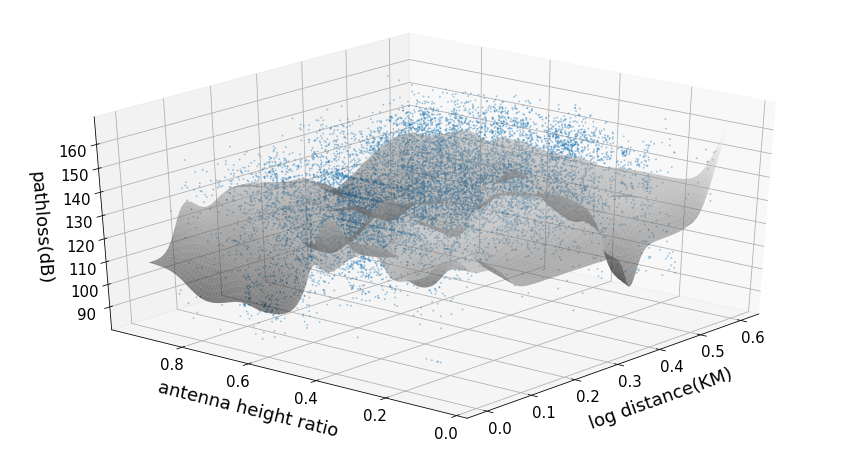

In [43]:
%autoreload
print("3D graph for log distance and antenna height ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","antenna height ratio","pathloss(dB)"
excludeCols = ['logDistance', 'logExtendedHeightTratio', 'pathloss']
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), excludeCols)

graphX = data[0]
graphY = data[1]
train_3d_graph_origin(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

data distribution(before)
       logDistance  logFrequency  logHeightTM  logExtendedHeightTratio    season  pathloss
count    393723.00     393723.00    393723.00                393723.00 393723.00 393723.00
mean          0.66          3.04         1.43                     0.56      0.52    138.16
std           0.21          0.32         0.21                     0.19      0.45     15.59
min           0.00          2.60         1.00                     0.02      0.00     85.47
25%           0.54          2.60         1.28                     0.42      0.00    127.03
50%           0.73          3.15         1.42                     0.58      0.50    139.54
75%           0.82          3.35         1.58                     0.71      1.00    150.72
max           0.90          3.35         2.00                     0.95      1.00    175.82
sampling shape(before):(393723, 6)
sampling shape(after):(118117, 6)
data distribution(after)
       logDistance  logFrequency  logHeightTM  logExtendedHei

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


count   118117.00
mean       138.23
std         15.57
min         85.63
25%        127.11
50%        139.62
75%        150.72
max        175.80
Name: pathloss, dtype: float64

Covariance Matrix - ADD data[Target Columns]
Target Columns: ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season', 'pathloss']
logDistance                 1.68
logFrequency                0.24
logHeightTM                 0.80
logExtendedHeightTratio    -0.75
season                      0.30
pathloss                  242.45
Name: pathloss, dtype: float64

Correlation Matrix - ADD data[Target Columns]
Target Columns: ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season', 'pathloss']
                         logDistance  logFrequency  logHeightTM  logExtendedHeightTratio  season  pathloss
logDistance                     1.00         -0.01         0.28                    -0.28   -0.03      0.51
logFrequency                   -0.01          1.00        -0.00  

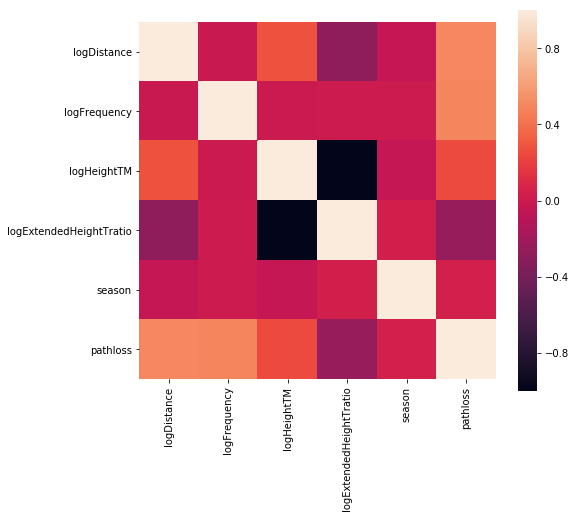

In [3]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'

samplingRatio = 0.1
addDataSampled = samplingData(addData[targetCols], samplingRatio, None)
# addDataSample.sort_values(by=['logDistance'])

sc = 'paju_5term'
scale = 'manual'

addDataNorm, normalizer = normalizeData(addDataSampled[targetCols], addDataSampled[yCols], scaler = scale)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addDataSampled[yCols])

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

bestANNModel = None
bestANNIdx = 0
modelList = []
dataSet = []
i = 1
prevTestError = 0

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    
    
    model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')
    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = 'model/ann_'+sc+'-'+str(i)+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    
    if i == 1:
        prevTestError = testError
        bestANNModel = model
        bestANNIdx = i
        
    if prevTestError > testError:
        bestANNModel = model
        bestANNIdx = i
        prevTestError = testError
    
    i+=1
print("bestIdx:",bestANNIdx)
print("best model:",bestANNModel)

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:9.915294784027973 / test:9.887535023564924
#2 Error(RMSE)-train:9.888811090440527 / test:9.874707679741615
#3 Error(RMSE)-train:9.804079143136798 / test:9.898089864050407
#4 Error(RMSE)-train:9.86545214748292 / test:9.840884191746747
#5 Error(RMSE)-train:9.884093756752609 / test:9.945738098143702
bestIdx: 4
best model: MLPRegressor(activation='logistic', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-06, validation_fraction=0.1,
       verbose=False, warm_start=False)


logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


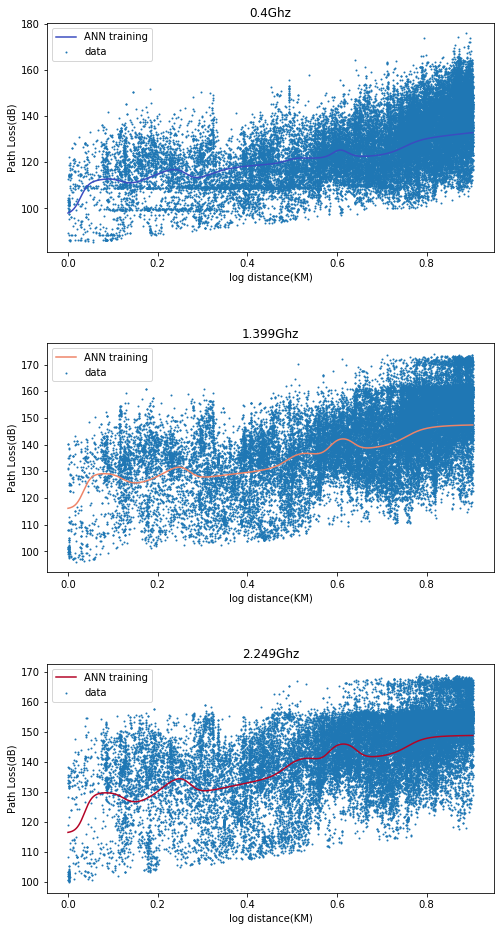

In [5]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'logHeightTM', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'logDistance', "log distance(KM)")

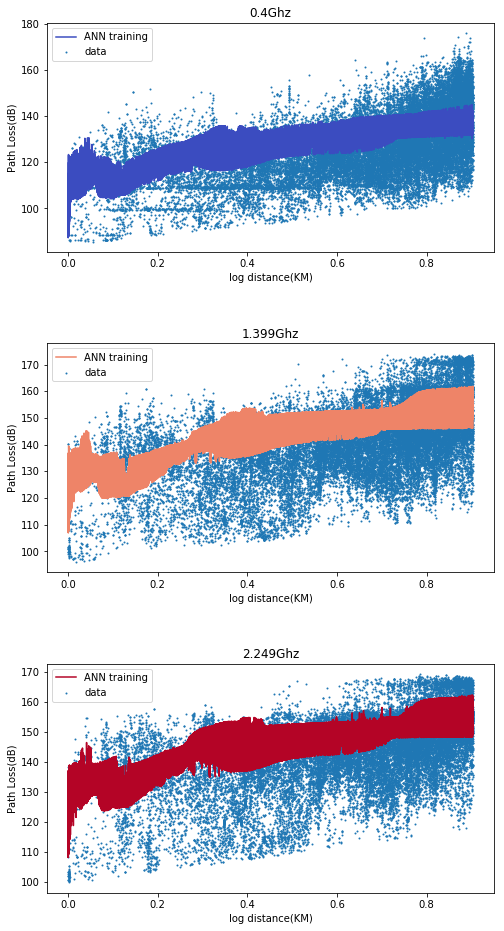

In [6]:
%autoreload
data = groupWithFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), 'logDistance')

graphX = data[0]
graphY = data[1]

train_2d_graph(bestANNModel, None, None, graphX, graphY, 'logDistance', "log distance(KM)", xCategory = ('0.4Ghz', '1.399Ghz', '2.249Ghz'), convertFlag=False)

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


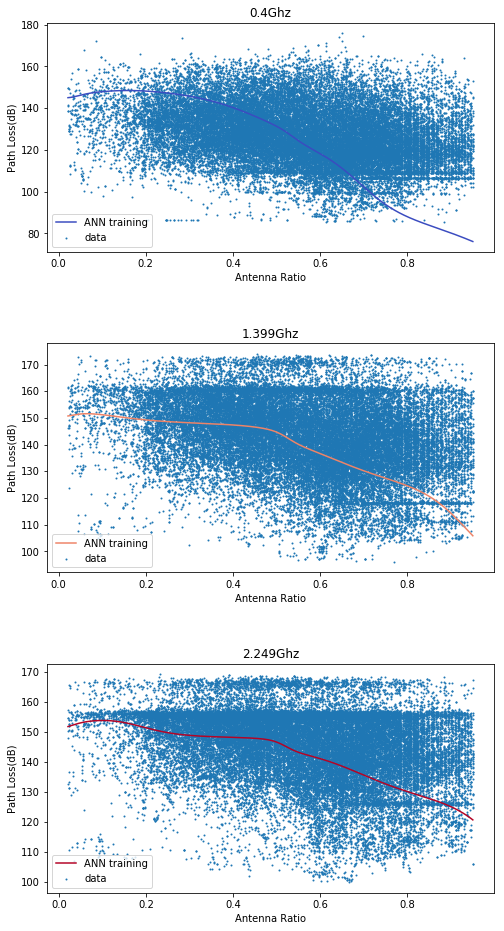

In [7]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'season', 'logHeightTM'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'logExtendedHeightTratio', "Antenna Ratio")

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


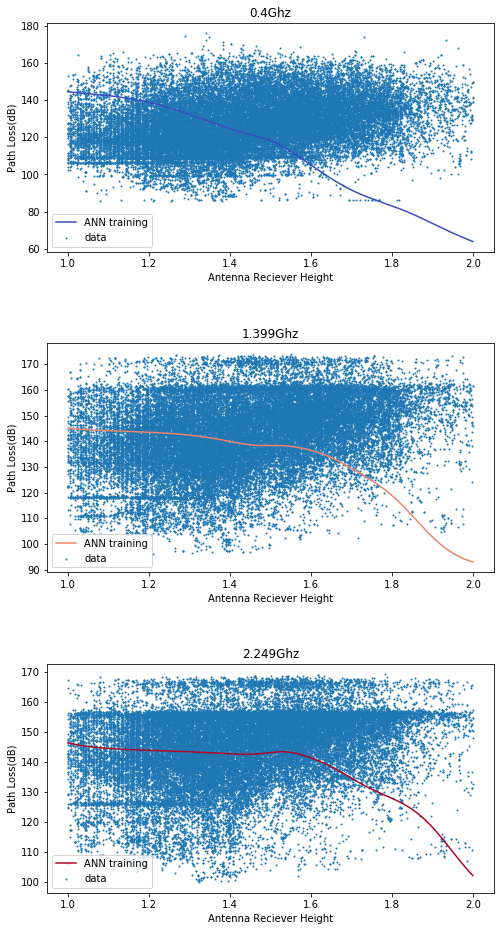

In [8]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'season', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'logHeightTM', "Antenna Reciever Height")

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


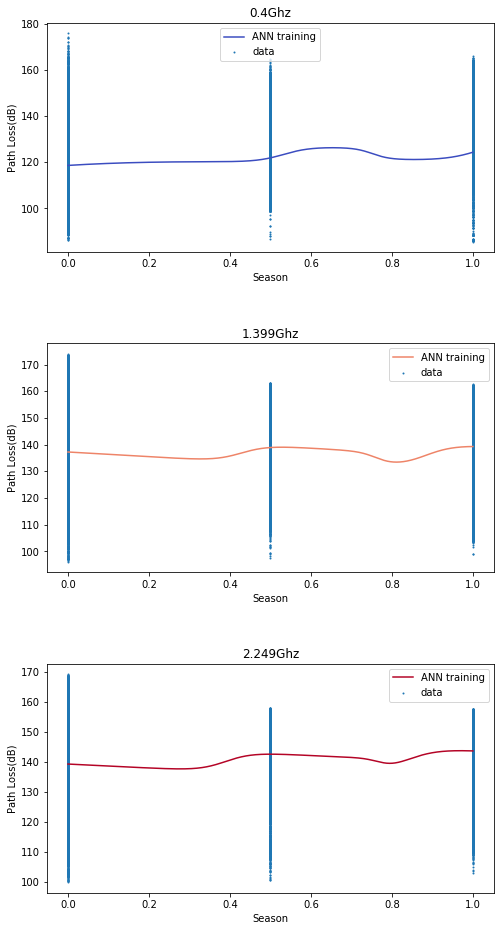

In [9]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logHeightTM', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, None, None,graphX, graphY, 'season', "Season")

3D graph for log distance and log frequency - trainset #1
logDistance                 0.66
logFrequency                0.30
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  138.23
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.45          0.30         1.43                     0.56     0.52
std           0.26          0.02         0.00                     0.00     0.00
min           0.00          0.26         1.43                     0.56     0.52
25%           0.23          0.28         1.43                     0.56     0.52
50%           0.45          0.30         1.43                     0.56     0.52
75%           0.68          

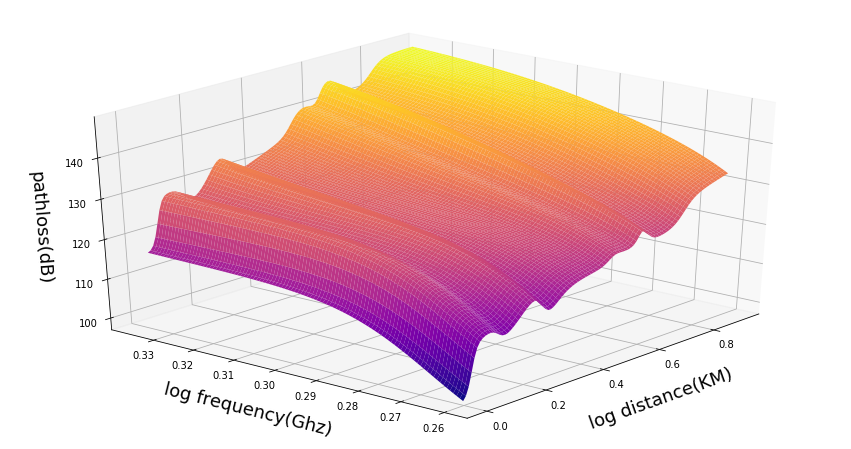

In [10]:
%autoreload
i = 1
print("3D graph for log distance and log frequency - trainset #{}".format(i))
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
logDistance                 0.66
logFrequency                0.30
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  138.23
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.45          0.30         1.43                     0.49     0.52
std           0.26          0.00         0.00                     0.27     0.00
min           0.00          0.30         1.43                     0.02     0.52
25%           0.23          0.30         1.43                     0.25     0.52
50%           0.45          0.30         1.43                     0.49     0.52
75%    

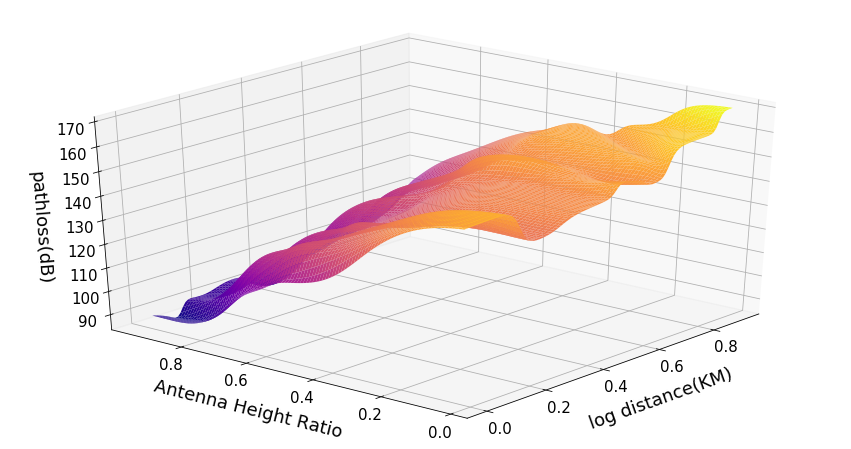

In [11]:
%autoreload
print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Height Ratio","pathloss(dB)"
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.66
logFrequency                0.30
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  138.23
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.45          0.30         1.43                     0.56     0.50
std           0.26          0.00         0.00                     0.00     0.29
min           0.00          0.30         1.43                     0.56     0.00
25%           0.23          0.30         1.43                     0.56     0.25
50%           0.45          0.30         1.43                     0.56     0.50
75%           0

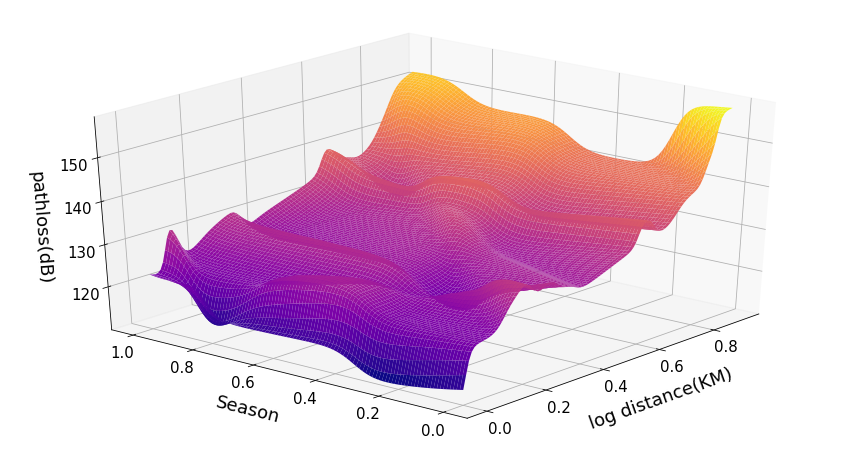

In [12]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logDistance', 'season']
xLabel,yLabel,zLabel = "log distance(KM)","Season","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B ratio - trainset #1
logDistance                 0.66
logFrequency                0.30
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  138.23
dtype: float64
Index(['logDistance', 'logFrequency', 'logHeightTM', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logHeightTM  logExtendedHeightTratio   season
count     10000.00      10000.00     10000.00                 10000.00 10000.00
mean          0.45          0.30         1.50                     0.56     0.52
std           0.26          0.00         0.29                     0.00     0.00
min           0.00          0.30         1.00                     0.56     0.52
25%           0.23          0.30         1.25                     0.56     0.52
50%           0.45          0.30         1.50                     0.56     0.52
75%           0

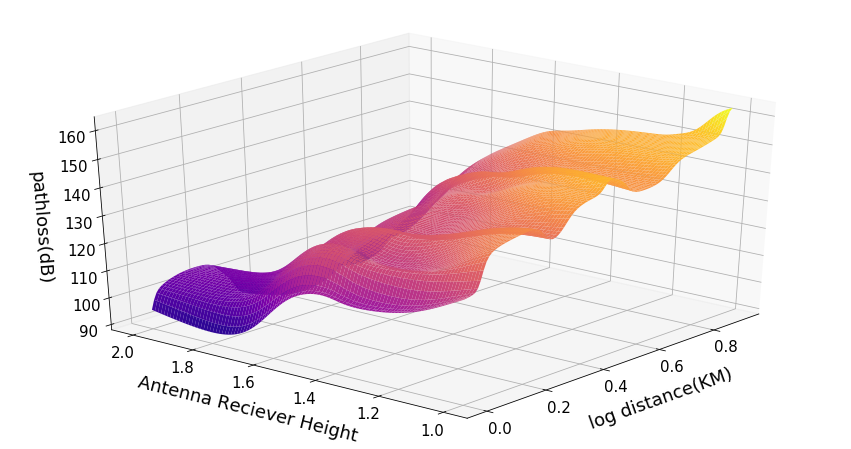

In [13]:
%autoreload
print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logDistance', 'logHeightTM']
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Reciever Height","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(bestANNModel, graphX, graphY, varX, xLabel, yLabel, zLabel)

----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1


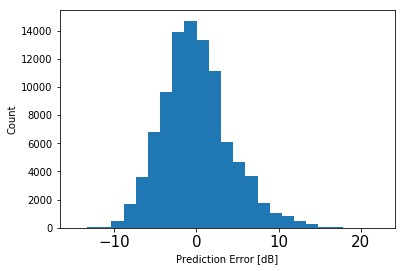

       Error(Noise) Distribution
count                   94493.00
mean                        0.00
std                         4.17
min                       -14.77
25%                        -2.79
50%                        -0.32
75%                         2.30
max                        22.25
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.87 7.74  5.77   0.07 0.60
ANN Test          9.82 7.72  5.74   0.07 0.60
Linear Train     10.73 8.52  6.36   0.08 0.53
Linear Test      10.67 8.46  6.30   0.08 0.53
Diff(ANN,Linear)  4.17 3.23  2.38   0.03 0.88

Objective Function
L_pathloss =  35.10log_d +  24.93log_f + -90.05log_hm1 + -106.39|log_(hb1/hm1)| +   2.17s + 227.21
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #2


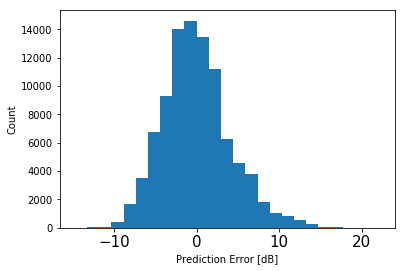

       Error(Noise) Distribution
count                   94493.00
mean                       -0.00
std                         4.17
min                       -14.79
25%                        -2.78
50%                        -0.32
75%                         2.29
max                        22.15
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.87 7.74  5.76   0.07 0.60
ANN Test          9.84 7.74  5.76   0.07 0.60
Linear Train     10.72 8.51  6.35   0.08 0.53
Linear Test      10.70 8.50  6.34   0.08 0.53
Diff(ANN,Linear)  4.17 3.23  2.37   0.03 0.88

Objective Function
L_pathloss =  35.06log_d +  24.93log_f + -93.75log_hm1 + -110.25|log_(hb1/hm1)| +   2.17s + 234.68
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #3


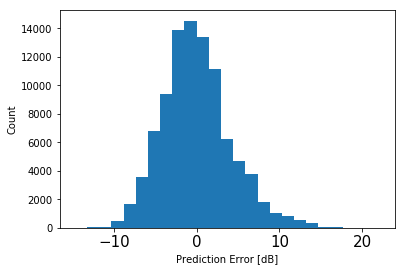

       Error(Noise) Distribution
count                   94494.00
mean                       -0.00
std                         4.17
min                       -14.75
25%                        -2.79
50%                        -0.32
75%                         2.30
max                        22.10
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.85 7.73  5.76   0.07 0.60
ANN Test          9.90 7.75  5.77   0.07 0.60
Linear Train     10.71 8.50  6.34   0.08 0.53
Linear Test      10.76 8.55  6.38   0.08 0.52
Diff(ANN,Linear)  4.17 3.23  2.38   0.03 0.88

Objective Function
L_pathloss =  35.14log_d +  24.93log_f + -92.87log_hm1 + -109.38|log_(hb1/hm1)| +   2.15s + 232.90
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #4


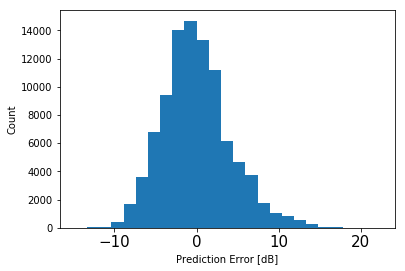

       Error(Noise) Distribution
count                   94494.00
mean                       -0.00
std                         4.17
min                       -14.81
25%                        -2.79
50%                        -0.31
75%                         2.31
max                        22.25
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.87 7.74  5.77   0.07 0.60
ANN Test          9.84 7.72  5.74   0.07 0.60
Linear Train     10.72 8.51  6.35   0.08 0.53
Linear Test      10.69 8.50  6.33   0.08 0.53
Diff(ANN,Linear)  4.17 3.23  2.38   0.03 0.88

Objective Function
L_pathloss =  35.08log_d +  24.89log_f + -88.80log_hm1 + -104.95|log_(hb1/hm1)| +   2.15s + 224.74
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #5


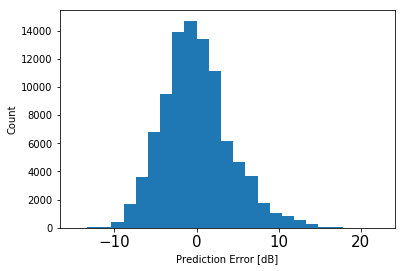

       Error(Noise) Distribution
count                   94494.00
mean                       -0.00
std                         4.18
min                       -14.81
25%                        -2.79
50%                        -0.32
75%                         2.31
max                        22.26
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.85 7.73  5.75   0.07 0.60
ANN Test          9.89 7.76  5.80   0.07 0.60
Linear Train     10.71 8.50  6.34   0.08 0.53
Linear Test      10.76 8.54  6.38   0.08 0.53
Diff(ANN,Linear)  4.18 3.24  2.38   0.03 0.88

Objective Function
L_pathloss =  35.08log_d +  24.92log_f + -88.02log_hm1 + -104.14|log_(hb1/hm1)| +   2.15s + 223.10
bestIdx: 5
best model: Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [14]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0
ANNmodel = bestANNModel
bestLinearModel = None
bestLinearIdx = 0
bestStat = None
prevTestError = 0

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("-"*100)
#     X_train = scaler.inverse_transform(X_train)
#     X_test = scaler.inverse_transform(X_test)
    print("Equation Derivation for trainset #{}".format(i))

    ANNPred = ANNmodel.predict(X_train)
    ANNPred_test = ANNmodel.predict(X_test)  
    linearModel = Ridge(alpha=0.0001)
    linearModel.fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_ANN_TRAIN = np.sqrt(mean_squared_error(y_train, ANNPred))
    RMSE_ANN_TEST = np.sqrt(mean_squared_error(y_test, ANNPred_test))
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(y_train, linearPredTrain))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(y_test, linearPredTest))
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))
    errorDist(ANNPred, linearPredTrain)    
    stat = np.array([RMSE_ANN_TRAIN, mean_absolute_error(y_train, ANNPred),mean_absolute_percentage_error(y_train, ANNPred),np.sqrt(mean_squared_log_error(y_train, ANNPred)),r2_score(y_train, ANNPred),\
                    RMSE_ANN_TEST, mean_absolute_error(y_test, ANNPred_test),mean_absolute_percentage_error(y_test, ANNPred_test),np.sqrt(mean_squared_log_error(y_test, ANNPred_test)),r2_score(y_test, ANNPred_test),\
                    RMSE_LIN_TRAIN, mean_absolute_error(y_train, linearPredTrain),mean_absolute_percentage_error(y_train, linearPredTrain),np.sqrt(mean_squared_log_error(y_train, linearPredTrain)),r2_score(y_train, linearPredTrain),\
                    RMSE_LIN_TEST, mean_absolute_error(y_test, linearPredTest),mean_absolute_percentage_error(y_test, linearPredTest), np.sqrt(mean_squared_log_error(y_test, linearPredTest)),r2_score(y_test, linearPredTest),\
                    RMSE_LIN_ANN, mean_absolute_error(ANNPred, linearPredTrain),mean_absolute_percentage_error(ANNPred, linearPredTrain), np.sqrt(mean_squared_log_error(ANNPred, linearPredTrain)),r2_score(ANNPred, linearPredTrain)])

    print(pd.DataFrame(stat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

    print("\nObjective Function")
    print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_hm1 + {:6.2f}|log_(hb1/hm1)| + {:6.2f}s + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[1]
              *0.1,linearModel.coef_[2],\
              linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_)) 
    if i == 1:
        prevTestError = RMSE_LIN_TEST
        bestLinearModel = linearModel
        bestLinearIdx = i
        bestStat = stat
    if prevTestError < RMSE_LIN_TEST:
        bestLinearModel = linearModel
        bestLinearIdx = i
        bestStat = stat
    i+=1
print("bestIdx:",bestLinearIdx)
print("best model:",bestLinearModel)

In [15]:
%autoreload
print("best model:")
print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_hm1 + {:6.2f}|log_(hb1/hm1)| + {:6.2f}s + {:6.2f}"\
      .format(bestLinearModel.coef_[0], bestLinearModel.coef_[1]*0.1, bestLinearModel.coef_[2],\
              bestLinearModel.coef_[3], bestLinearModel.coef_[4], bestLinearModel.intercept_)) 
print(pd.DataFrame(bestStat.reshape((5,5)),index=pd.Index(['ANN Train','ANN Test','Linear Train','Linear Test','Diff(ANN,Linear)']), columns=pd.Index(['RMSE','MAE','MAPE','RMSLE','R2'],name='TEST ERROR(dB)')))

best model:
L_pathloss =  35.08log_d +  24.92log_f + -88.02log_hm1 + -104.14|log_(hb1/hm1)| +   2.15s + 223.10
TEST ERROR(dB)    RMSE  MAE  MAPE  RMSLE   R2
ANN Train         9.85 7.73  5.75   0.07 0.60
ANN Test          9.89 7.76  5.80   0.07 0.60
Linear Train     10.71 8.50  6.34   0.08 0.53
Linear Test      10.76 8.54  6.38   0.08 0.53
Diff(ANN,Linear)  4.18 3.24  2.38   0.03 0.88


logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64
original_L_pathloss =  37.89log_d + 102.06
original_L_pathloss =  39.47log_d + 116.66
original_L_pathloss =  34.39log_d + 122.29


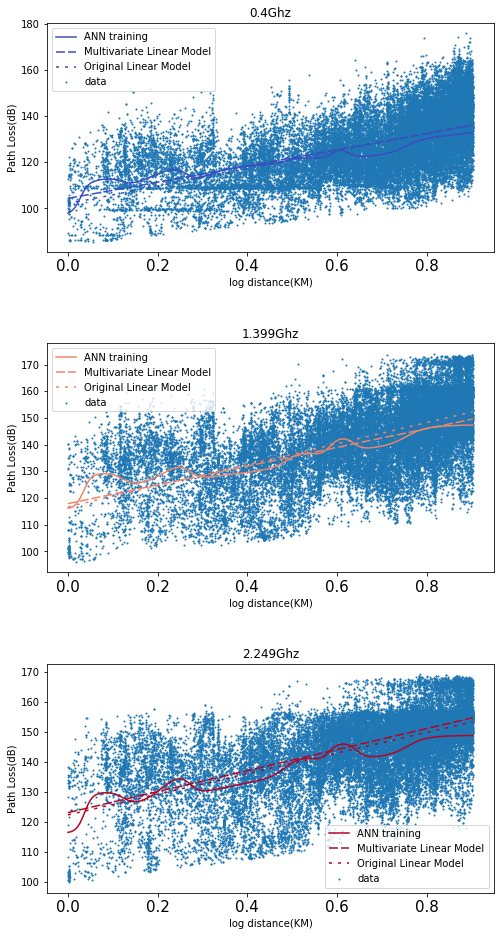

In [16]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'logHeightTM', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, True, graphX, graphY, 'logDistance', "log distance(KM)")

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


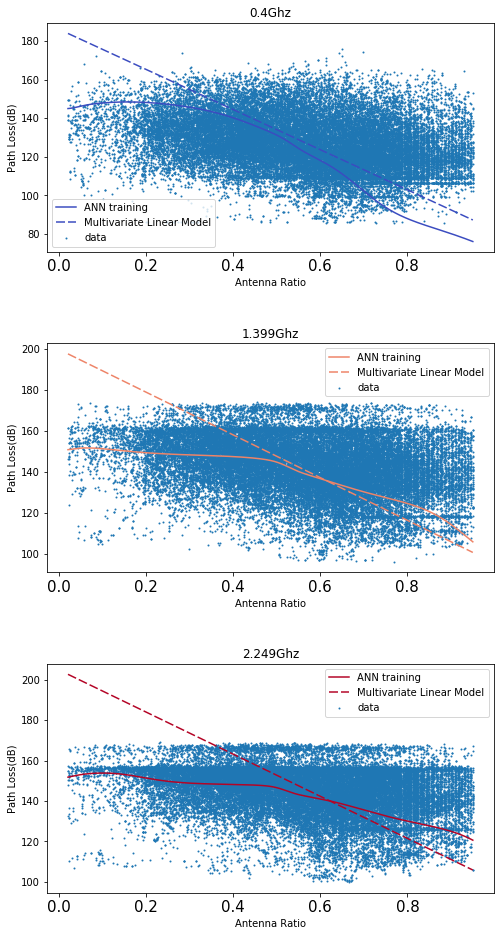

In [17]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logHeightTM', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, None, graphX, graphY, 'logExtendedHeightTratio', "Antenna Ratio")

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


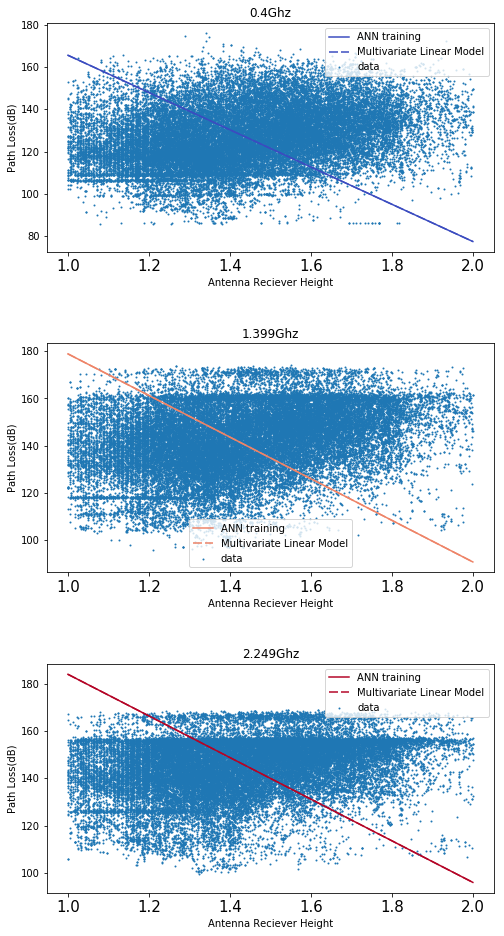

In [18]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'logDistance', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestLinearModel, linearModel, None, graphX, graphY, 'logHeightTM', "Antenna Reciever Height")

logDistance                 0.66
logFrequency                0.26
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  127.09
dtype: float64
logDistance                 0.66
logFrequency                0.31
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  142.52
dtype: float64
logDistance                 0.66
logFrequency                0.34
logHeightTM                 1.43
logExtendedHeightTratio     0.56
season                      0.52
pathloss                  144.86
dtype: float64


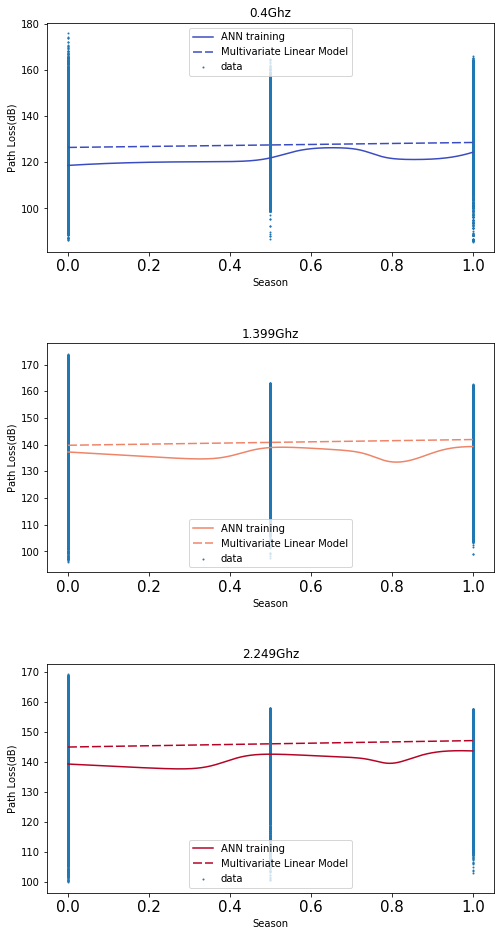

In [19]:
%autoreload
data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logHeightTM', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(bestANNModel, bestLinearModel, None, graphX, graphY, 'season', "Season")